# EXC RB simulation

Luca Mechelli, Tim Keil

In [ ]:
# ~~~
# This file is part of the paper:
#
#  "A NON-CONFORMING DUAL APPROACH FOR ADAPTIVE TRUST-REGION REDUCED BASIS
#           APPROXIMATION OF PDE-CONSTRAINED OPTIMIZATION"
#
#   https://github.com/TiKeil/NCD-corrected-TR-RB-approach-for-pde-opt
#
# Copyright 2019-2020 all developers. All rights reserved.
# License: Licensed as BSD 2-Clause License (http://opensource.org/licenses/BSD-2-Clause)
# ~~~

# Preparations

## details

In this notebook we discretize the following problem: 
Find $u_{\mu}$ solving the following parametrized constrained equation

\begin{align*}
	-  \nabla \cdot \left( \kappa_{\mu}  \nabla u_{\mu} \right) &= f_{\mu} &&\text{in } \Omega, \\
	 ( \kappa_{\mu}  \nabla u_{\mu} \cdot n) &= c_{\mu}(u_{\text{out}} - u_{\mu}) &&\text{on } \partial \Omega.
\end{align*}

For the definition of $\kappa_{\mu}$ and $f_{\mu}$ in the computational domain $\Omega$, we use the `BitmapFunction` from PyMOR. This function uses the Python Imaging Library (PIL) in order to convert a .png grayscale picture to a data function on our domain.
Walls, windows and doors are stored in seperated .png to enable a affine decomposition of each part of the picture. Furthermore, we are considering a heater at each window. The numbering of the components for $\kappa_{\mu}$ can be seen in the following picture
![EXC_notebook_data/EXC_MM_with_numbers.png](../../EXC_notebook_data/Domain_of_interestin_Omega.png)

Here, numbers with | are walls, numbers with _ are doors and numbers with dots are windows

The heaters are numbered in the following way:
![EXC_notebook_data/EXC_MM_with_numbers_heat.png](../../EXC_notebook_data/EXC_MM_with_numbers_heat.png)

For our pde constrained model, we need to define a cost functional. In a general quadratic model, we have 

\begin{align}
\mathcal{J}(u, \mu) := \Theta(\mu) + j_\mu(u) + k_\mu(u, u),
\end{align}

For this code, we restrict ourselves to the following definition
\begin{align}
\mathcal{J}(v, \mu) = \frac{\sigma_D}{2} \int_{D}^{} (v - u^{\text{d}})^2 + \frac{1}{2} \sum^{M}_{i=1} \sigma_i (\mu_i-\mu_i^d)^2 + 1,
\end{align}
which means

\begin{align}
\Theta(\mu) &= \frac{1}{2} \sum^{M}_{i=1} \sigma_i (\mu_i-\mu_i^d)^2 + \frac{\sigma_D}{2} \int_{D}^{} u^{\text{d}} u^{\text{d}}  + 1\\
j_{\mu}(u) & = -\sigma_D \int_{D}^{} u^{\text{d}}u \\
k_{\mu}(u,v) &= \frac{\sigma_D}{2} \int_{D}^{} u\,v 
\end{align}

The following code implements this particular case.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})

In [2]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

data_path = '../../../EXC_data'

# domain of interest
bounding_box = [[0,0],[2,1]]
domain_of_interest = BitmapFunction('{}/Domain_of_interest.png'.format(data_path), range=[1,0], bounding_box=bounding_box)

## problem definition

In [3]:
from pdeopt.problems import EXC_problem, set_input_dict
from pdeopt.discretizer import discretize_quadratic_pdeopt_stationary_cg

parametric_quantities = {'walls': [1,4,9], 'windows': [], 'doors': [], 'heaters': [1,3,5,6,7,8,9]}
inactive_quantities = {'removed_walls': [], 'open_windows': [], 'open_doors': [1,2,3,4,5,6,7,10], 'active_heaters': []}
summed_quantities = {'walls': [[1,2,3,8],[4,5,6,7]], 'windows': [], 'doors': [], 'heaters': [[1,2],[3,4],[9,10,11,12]]}

coefficient_expressions = None

parameters_in_q = True
input_dict = set_input_dict(parametric_quantities, inactive_quantities, coefficient_expressions, summed_quantities, parameters_in_q,
                            ac=0.5, owc=[0.025,0.1], iwc= [0.025,0.1], idc=[0.005], wc=[0.0005], ht=[0,100],
                                    owc_c=0.001,  iwc_c= 0.025,     idc_c=0.01,  wc_c=0.025,  ht_c=80)


parameter_scaling = False
u_out = 5

problem, parameter_scales = EXC_problem(input_dict, summed_quantities, outside_temperature=u_out, #, q_inverse=0.0001
                                        data_path = data_path,parameters_in_q=parameters_in_q, 
                                        parameter_scaling=parameter_scaling,
                                        coefficient_expressions=coefficient_expressions)

u_d = 18 

mu_d = None 

sigma_d = 100
weights = {'walls': [0.5,0.25,0.05], 'doors': 1, 'heaters': [0.002,0.002,0.001,0.001,0.001,0.001,0.004], 'windows': 1, 'state': sigma_d}

diameter = np.sqrt(2)/200.
opt_fom, data, mu_bar = discretize_quadratic_pdeopt_stationary_cg(problem, diameter, weights, parameter_scales, 
                                                          domain_of_interest, desired_temperature=u_d, 
                                                          mu_for_u_d=mu_d, mu_for_tikhonov=mu_d,
                                                          parameters_in_q=parameters_in_q, product='fixed_energy',
                                                          use_corrected_gradient= True)

I am using the corrected functional!!
I am using the corrected gradient!!
{heaters: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], walls: [0.049999999999999996, 0.049999999999999996, 0.049999999999999996]}
my product is fixed_energy


In [4]:
print('information on the grid:')
print(data['grid'])

radius = 0.1               # TR radius 
FOC_tolerance = 1e-6       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 40                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)

information on the grid:
Rect-Grid on domain [0,2] x [0,1]
x0-intervals: 400, x1-intervals: 200
faces: 80000, edges: 160600, vertices: 80601


Now we pick one specific starting parameter

In [5]:
# starting with
mu = problem.parameter_space.sample_randomly(1, seed= 13)[0]
print(mu)

{heaters: [77.77024105738202, 23.75412200349123, 82.42785326613685, 96.57491980429998, 97.26011139048933, 45.34492474173122, 60.90424627612779], walls: [0.08316448859536352, 0.0731210008569302, 0.07915136721377106]}


## Visualizations

Visualize the position of left- and right-hand sides parameters

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f821a9edf90>

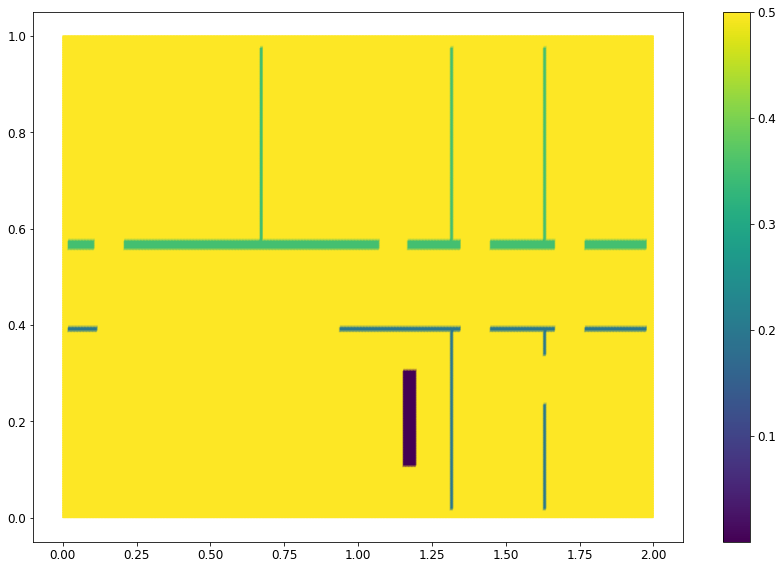

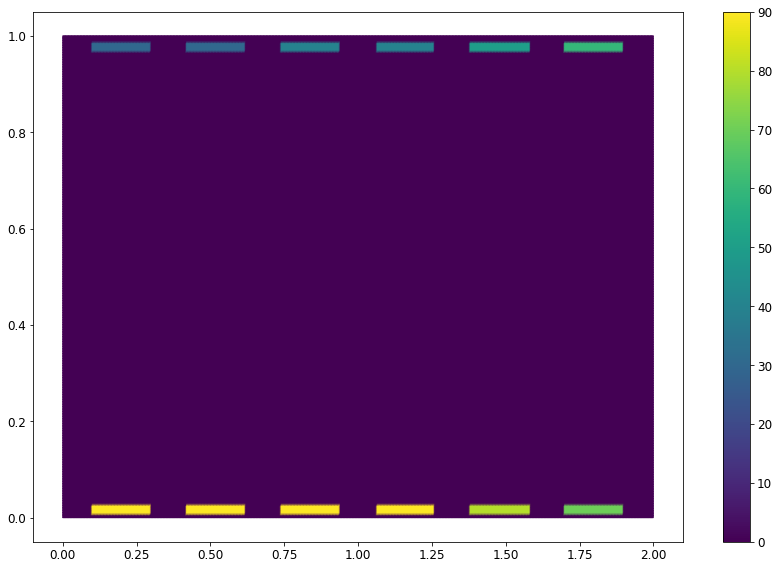

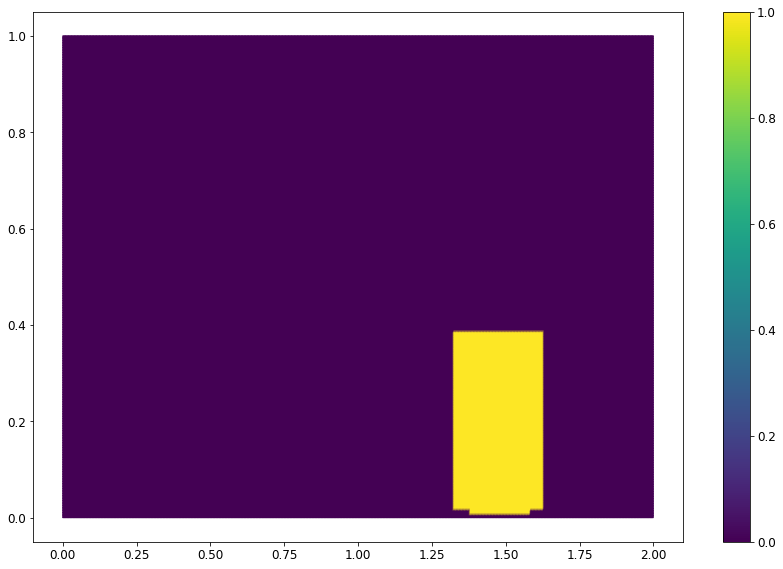

In [6]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = problem.parameter_space.sample_randomly(1, seed= 13)[0]
vis_mu['walls'][0] = 0.35
vis_mu['walls'][1] = 0.2
vis_mu['walls'][2] = 0.0001
vis_mu['heaters'][0] = 30
vis_mu['heaters'][1] = 40
vis_mu['heaters'][2] = 50
vis_mu['heaters'][3] = 60
vis_mu['heaters'][4] = 70
vis_mu['heaters'][5] = 80
vis_mu['heaters'][6] = 90
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
doI = InterpolationOperator(data['grid'], domain_of_interest).as_vector(vis_mu)
opt_fom.visualize(diff)
opt_fom.visualize(rhs)
#plt.savefig('exc_2_rhs.pdf', format='pdf', bbox_inches="tight")
opt_fom.visualize(doI)

We can easily solve the primal and dual equations by calling 

<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f822106b590>

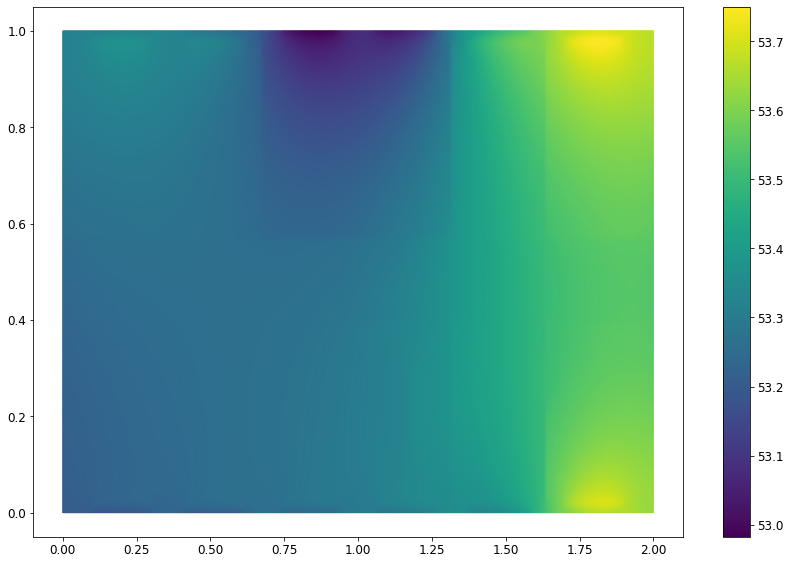

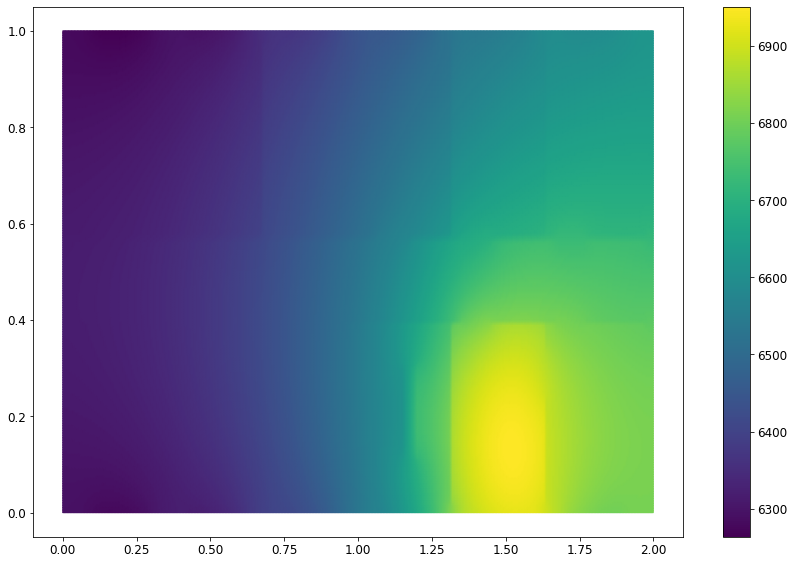

In [7]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)
opt_fom.visualize(p)

# Full Order Optimization

In [8]:
mu_opt = opt_fom.parse_parameter(opt_fom.pre_parse_parameter([1.651891986460e+01, 1.692820877511e+01, 1.732387911116e+01, 1.746951227840e+01, 
                                                                 1.812299797114e+01, 1.840759241105e+01, 1.693448657882e+01, 2.500000000000e-02, 
                                                                 2.500000000000e-02, 2.500000000000e-02]))
mu_opt_as_array = opt_fom.parse_parameter_inverse(mu_opt)
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', opt_fom.parse_parameter_inverse(mu))
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [16.51891986 16.92820878 17.32387911 17.46951228 18.12299797 18.40759241
 16.93448658  0.025       0.025       0.025     ]
Optimal J:  2.772773184915195

Starting parameter:  [7.77702411e+01 2.37541220e+01 8.24278533e+01 9.65749198e+01
 9.72601114e+01 4.53449247e+01 6.09042463e+01 8.31644886e-02
 7.31210009e-02 7.91513672e-02]
Starting J:  7354.198111456504


## FOM BFGS

In [9]:
from pdeopt.TR import solve_optimization_subproblem_BFGS
from pdeopt.tools import compute_errors, compute_actual_errors

TR_parameters = {'radius': 1.e18, 'sub_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True }


muoptfom,_,_,_, times_2, mus_2, Js_2, FOC_2 = solve_optimization_subproblem_BFGS(opt_fom,opt_fom.parameter_space,mu,TR_parameters, timing=True)
times_full_2, J_error_2, mu_error_2 = compute_errors(opt_fom, J_start, J_opt, mu, mu_opt_as_array, 
                                               mus_2, Js_2, times_2, 0)

Starting parameter {heaters: [77.77024105738202, 23.75412200349123, 82.42785326613685, 96.57491980429998, 97.26011139048933, 45.34492474173122, 60.90424627612779], walls: [0.08316448859536352, 0.0731210008569302, 0.07915136721377106]}
Step [27.27707752  0.         56.11255203 70.07202604 69.86939416 17.61618742
  0.          0.1         0.1         0.1       ], functional 108.43169470208431 , FOC condition 8.725128573042713
Step [19.74774973  0.         52.16145858 66.08067699 65.74929366 13.4979845
  0.          0.1         0.1         0.1       ], functional 34.71759845474298 , FOC condition 4.613364286627023
Step [ 4.33856556  0.         44.04178251 57.86590817 57.27114741  5.07155784
  0.          0.1         0.1         0.1       ], functional 25.709310480069007 , FOC condition 7.171686126240818
Step [1.04998932e+01 1.35710160e+00 4.72630356e+01 6.11153736e+01
 6.06263528e+01 8.44359301e+00 2.71382980e+00 2.50000000e-02
 2.50000000e-02 2.50000000e-02], functional 8.33227682778488 

Step [16.50977974 16.97383473 17.3182507  17.47115828 18.12677789 18.40392109
 16.92212673  0.025       0.025       0.025     ], functional 2.7727846052296172 , FOC condition 0.004750769175332061
Step [16.50535012 16.94267602 17.32030661 17.46922479 18.12638186 18.41955806
 16.93140565  0.025       0.025       0.025     ], functional 2.7727738638568553 , FOC condition 0.0006734691153800644
Step [16.51761162 16.93010475 17.31840312 17.47019679 18.1264715  18.40881571
 16.93413721  0.025       0.025       0.025     ], functional 2.7727732125849798 , FOC condition 8.243864431590751e-06
Step [16.51888434 16.92830052 17.31836149 17.47023647 18.12649109 18.40854678
 16.93448167  0.025       0.025       0.025     ], functional 2.7727732070736693 , FOC condition 8.233080378311167e-06
Step [16.51895205 16.92825139 17.31834378 17.47020481 18.12645679 18.40854545
 16.93450032  0.025       0.025       0.025     ], functional 2.7727732070134152 , FOC condition 6.663741340217494e-06
Step [16.5190313

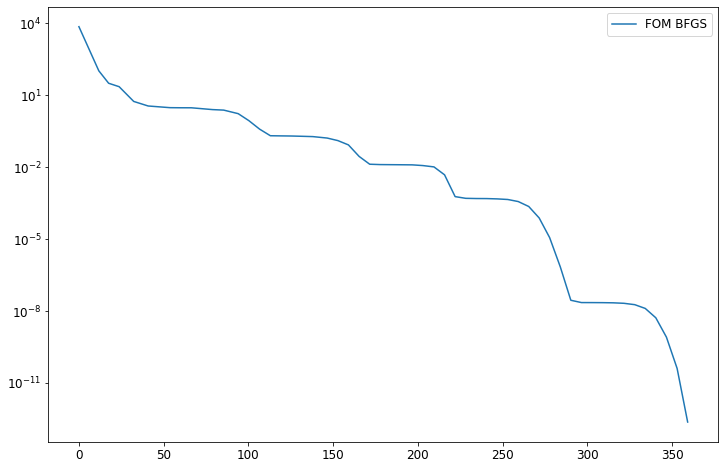

In [10]:
plt.semilogy(times_full_2,J_error_2, label='FOM BFGS')
plt.legend()

# TR approach

In [11]:
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor

from pymor.parameters.functionals import MinThetaParameterFunctional

ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

## BFGS (Lagrange-Basis)

#### NCD-Corrected Functional - Variant 3(a)

In [12]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=True)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar,
                                                            adjoint_estimate=True)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}

from pdeopt.TR import TR_algorithm

mus_23, times_23, Js_23, FOC_23 = TR_algorithm(opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_23_actual, J_error_23_actual, mu_error_23_actual, FOC_23_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_23[1:], Js_23, times_23, tictoc, FOC_23)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {heaters: [77.77024105738202, 23.75412200349123, 82.42785326613685, 96.57491980429998, 97.26011139048933, 45.34492474173122, 60.90424627612779], walls: [0.08316448859536352, 0.0731210008569302, 0.07915136721377106]}
Starting value of the cost: 7354.198110398802
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 1 - Cost Functional: 1007.5754939311355 - mu: {heaters: [52.523659293268054, 0.0, 69.27020265165187, 83.32347292335959, 83.56475277532886, 31.480556081737596, 9.336599716688134], walls: [0.1, 0.1, 0.1]}
computing the fom gradient since the model was enriched
First order critical condition: 28.859713966820422
***********************

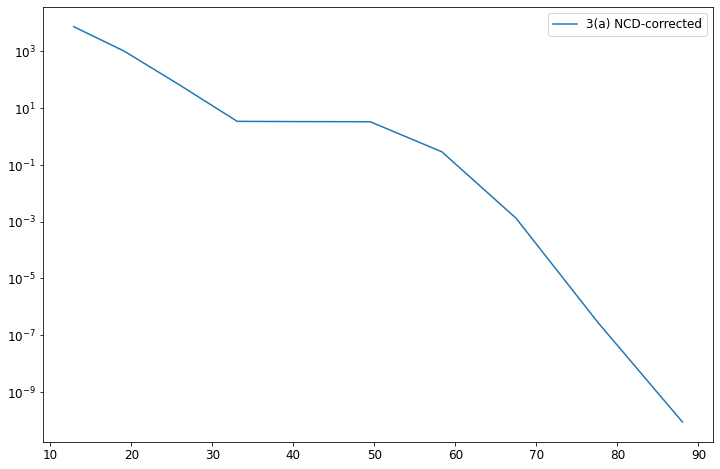

In [13]:
plt.semilogy(times_full_23_actual,J_error_23_actual, label='3(a) NCD-corrected')
plt.legend()

#### Standard approach - Variant 1(a)

In [14]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = { 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": True, 'timings': True}
from pdeopt.TR import TR_algorithm
mus_25, times_25, Js_25, FOC_25 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_25_actual, J_error_25_actual, mu_error_25_actual, FOC_25_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_25[1:], Js_25, times_25, tictoc, FOC_25)


Starting with two bases. Primal and dual have length 1 and 1
starting parameter {heaters: [77.77024105738202, 23.75412200349123, 82.42785326613685, 96.57491980429998, 97.26011139048933, 45.34492474173122, 60.90424627612779], walls: [0.08316448859536352, 0.0731210008569302, 0.07915136721377106]}
Starting value of the cost: 7354.1981104136885
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 4 - Cost Functional: 1180.6776384879831 - mu: {heaters: [54.083272585334065, 0.0, 70.06995671032331, 84.1207968429991, 84.39031550682694, 32.348158943730404, 12.662412356477537], walls: [0.1, 0.1, 0.1]}
computing the fom gradient since the model was enriched
First order critical condition: 32.44575018371194
**********************

Enrichment completed... length of Bases are 12, 12, [] and []
k: 10 - j 12 - Cost Functional: 2.772773017877171 - mu: {heaters: [16.516699445624415, 16.926256004574164, 17.32442304469808, 17.472058193618636, 18.125613086561586, 18.404517348417485, 16.935866185588534], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 2.076525648007908e-05
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Subproblem converged: FOC = 5.007104895537044e-06, mu_diff = 1.907817491472026e-15, J_diff = 0.0 
relative differences mu 1.907817491472026e-15 and J 0.0
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 13, 13, [] and []
k: 11 - j 14 - Cost Functional: 2.77277308519524 - mu: {heaters: [16.519024547446044, 16.928231511296882, 17.323752409511645, 17.469423103304926, 18.122906570700703, 18.407423217411083, 16.9345

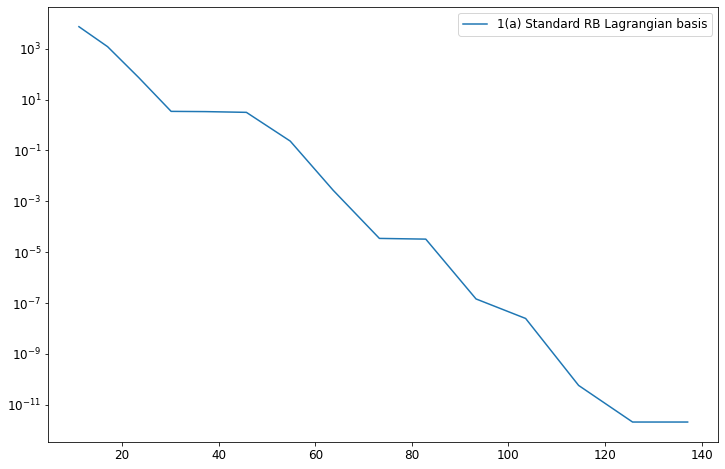

In [15]:
plt.semilogy(times_full_25_actual,J_error_25_actual, label='1(a) Standard RB Lagrangian basis')
plt.legend()

#### Qian et al. 2017 version

In [16]:
#Qian-Grepl
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
tic = time.time()
params = [mu]


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product, 
                                                            coercivity_estimator=ce, mu_bar=mu_bar,
                                                            prepare_for_gradient_estimate= True)

opt_rom = pdeopt_reductor.reduce()
tictoc = time.time() - tic

TR_parameters = {'Qian-Grepl': True,
                 'beta': beta, 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i,  
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod'}

extension_params = {"Enlarge_radius": False, 'timings': True}

mus_26, times_26,Js_26, FOC_26, opt_rom = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params, return_opt_rom=True)

times_full_26_actual, J_error_26_actual, FOC_26_actual, mu_error_26_actual = compute_actual_errors(
    opt_fom, J_start, J_opt, mus_26, times_26, tictoc, mu, mu_opt_as_array)

Starting with two bases. Primal and dual have length 1 and 1
GRAD J ESTIMATOR: non corrected estimator
QIAN et al. 2017 Method
starting parameter {heaters: [77.77024105738202, 23.75412200349123, 82.42785326613685, 96.57491980429998, 97.26011139048933, 45.34492474173122, 60.90424627612779], walls: [0.08316448859536352, 0.0731210008569302, 0.07915136721377106]}
Starting value of the cost: 7354.1981104136885
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting the enrichment
Enrichment completed... length of Bases are 2, 2, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 0 - j 4 - Cost Functional: 1180.6776384879831 - mu: {heaters: [54.083272585334065, 0.0, 70.06995671032331, 84.1207968429991, 84.39031550682694, 32.348158943730404, 12.662412356477537], walls: [0.1, 0.1, 0.1]}
estimate_gradient 1.

Subproblem converged: FOC = 0.001280010157671508, mu_diff = 2.0420210103540887e-13, J_diff = 0.0 
relative differences mu 2.0420210103540887e-13 and J 0.0
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 12, 12, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 10 - j 21 - Cost Functional: 2.772774979884389 - mu: {heaters: [16.515301583873505, 16.929289968886703, 17.31589921035645, 17.479883492889208, 18.131263351657505, 18.357130035693796, 16.946103526175637], walls: [0.025, 0.025, 0.025]}
estimate_gradient 9.02652513823481e-06
First order critical condition: 0.00046585900677908895
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Subproblem converged: FOC = 3.7382799856807934e-06, mu_diff = 7.718047241081197e-17, J_diff = 0.0 
relative differences mu 7.718047241081197e-17 and J 0.0
checked sufficient condition, starting the enrichment
Enrichment completed

estimate_gradient 9.061737333080629e-06
First order critical condition: 1.1396142880179333e-07
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Subproblem converged: FOC = 1.1396142449352217e-07, mu_diff = 1.1881990983481754e-15, J_diff = 0.0 
relative differences mu 1.1881990983481754e-15 and J 0.0
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 23, 23, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 21 - j 1 - Cost Functional: 2.7727731851452972 - mu: {heaters: [16.518951274949664, 16.928196625664775, 17.323877544590474, 17.469538650783306, 18.12302915444168, 18.407560291058935, 16.934471315872774], walls: [0.025, 0.025, 0.025]}
estimate_gradient 9.249047235067903e-06
First order critical condition: 1.1396143647247746e-07
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Cur

Enrichment completed... length of Bases are 24, 30, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 31 - j 1 - Cost Functional: 2.7727731851455246 - mu: {heaters: [16.518951274949664, 16.928196625664775, 17.323877544590474, 17.469538650783306, 18.12302915444168, 18.407560291058935, 16.934471315872777], walls: [0.025, 0.025, 0.025]}
estimate_gradient 9.146984013766769e-06
First order critical condition: 1.1396143647247746e-07
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
Curvature condition: 0.0
Reset direction to - gradient
Subproblem converged: FOC = 1.1396143647247746e-07, mu_diff = 0.0, J_diff = 0.0 
relative differences mu 0.0 and J 0.0
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 24, 31, [] and []
GRAD J ESTIMATOR: non corrected estimator
k: 32 - j 1 - Cost Functional: 2.7727731851455246 - mu: {heaters: [16.518951274949664, 16.928196625664775

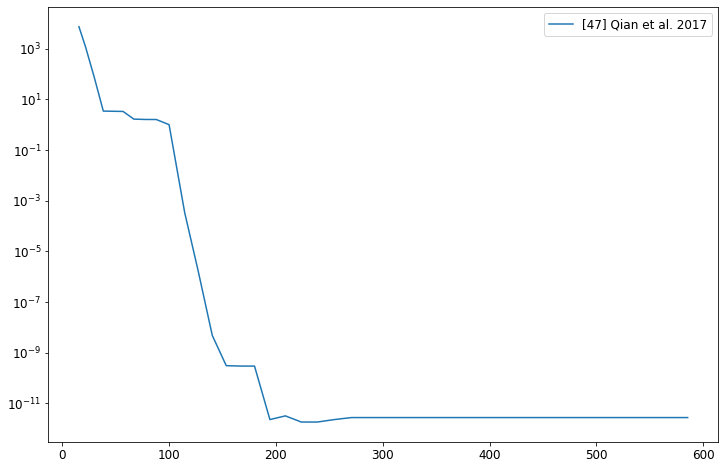

In [17]:
plt.semilogy(times_full_26_actual,J_error_26_actual, label='[47] Qian et al. 2017')
plt.legend()

#### semi NCD-corrected (Variant 2a)

In [18]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                            RBbasis, dual_RBbasis, 
                                                            opt_product=opt_fom.opt_product,
                                                            coercivity_estimator=ce,
                                                            mu_bar=mu_bar)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic

TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_39, times_39, Js_39, FOC_39 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_39_actual, J_error_39_actual, mu_error_39_actual, FOC_39_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_39[1:], Js_39, times_39, tictoc, FOC_39)

Starting with two bases. Primal and dual have length 1 and 1
starting parameter {heaters: [77.77024105738202, 23.75412200349123, 82.42785326613685, 96.57491980429998, 97.26011139048933, 45.34492474173122, 60.90424627612779], walls: [0.08316448859536352, 0.0731210008569302, 0.07915136721377106]}
Starting value of the cost: 7354.198110398802
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Enrichment completed... length of Bases are 2, 2, [] and []
k: 0 - j 1 - Cost Functional: 1007.5754939214166 - mu: {heaters: [52.52365929318313, 0.0, 69.27020265160925, 83.3234729233168, 83.56475277528611, 31.480556081695084, 9.336599716518478], walls: [0.1, 0.1, 0.1]}
computing the fom gradient since the model was enriched
First order critical condition: 28.859713966640047
*************************

Enrichment completed... length of Bases are 12, 12, [] and []
k: 10 - j 6 - Cost Functional: 2.7727731851446595 - mu: {heaters: [16.51891954550957, 16.92820288507886, 17.323871799757317, 17.469509172650078, 18.123005390244767, 18.40760253104579, 16.934487623987714], walls: [0.025, 0.025, 0.025]}
computing the fom gradient since the model was enriched
First order critical condition: 2.76432005768878e-08
******************************* 


Stopping criteria fulfilled: FOM FOC condition 2.76432005768878e-08 


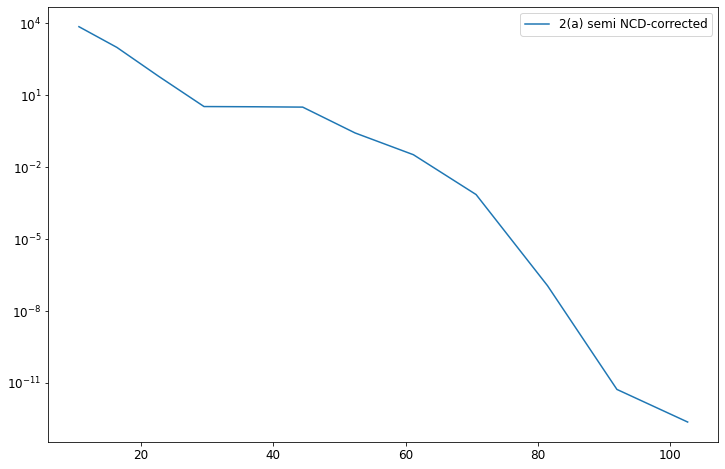

In [19]:
plt.semilogy(times_full_39_actual,J_error_39_actual, label='2(a) semi NCD-corrected')
plt.legend()

## TR BFGS - Single Basis - Variant 1(b)

In [20]:
import time
tic = time.time()
params = [mu]
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(use_corrected_gradient=False)
opt_fom = opt_fom.with_(adjoint_approach=False)


RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params, build_sensitivities=False)

pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                        RBbasis, dual_RBbasis, 
                                                        opt_product=opt_fom.opt_product,
                                                        coercivity_estimator=ce,
                                                        unique_basis=True,
                                                        mu_bar=mu_bar,
                                                        true_lagrange=False)

opt_rom = pdeopt_reductor.reduce()

tictoc = time.time() - tic


TR_parameters = {'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha,
                 'epsilon_i': epsilon_i, 
                 'starting_parameter': mu}

extension_params = {"Enlarge_radius": True, 'timings': True}

mus_54, times_54, Js_54, FOC_54 = TR_algorithm(
    opt_rom, pdeopt_reductor, TR_parameters, extension_params)

times_full_54_actual, J_error_54_actual, mu_error_54_actual, FOC_54_actual = compute_errors(
    opt_fom, J_start, J_opt, mu, mu_opt_as_array, mus_54[1:], Js_54, times_54, tictoc, FOC_54)

Starting with only one basis with length 2
starting parameter {heaters: [77.77024105738202, 23.75412200349123, 82.42785326613685, 96.57491980429998, 97.26011139048933, 45.34492474173122, 60.90424627612779], walls: [0.08316448859536352, 0.0731210008569302, 0.07915136721377106]}
Starting value of the cost: 7354.19811040782
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
enriching to check the sufficient decrease condition
Length of Basis is 4
k: 0 - j 2 - Cost Functional: 947.3696754352704 - mu: {heaters: [52.00020224884959, 0.0, 68.99742387530628, 83.04839719869041, 83.28115824784248, 31.195395734001153, 8.27611812025695], walls: [0.1, 0.1, 0.1]}
computing the fom gradient since the model was enriched
First order critical condition: 27.737456671839357
******************************* 

___ starting subproblem
Computing the approximate 

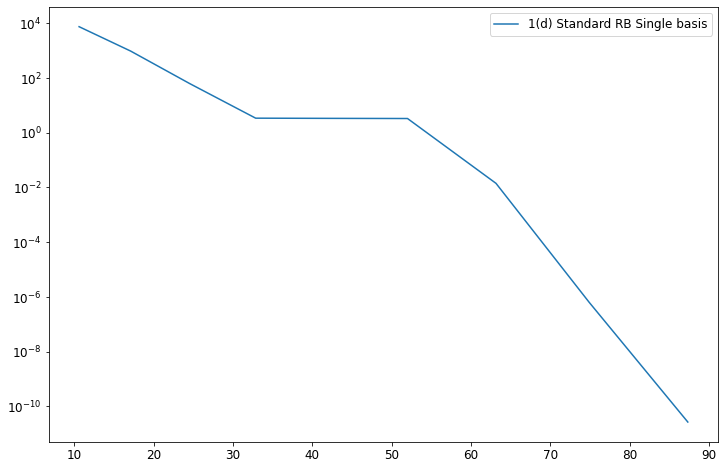

In [21]:
plt.semilogy(times_full_54_actual,J_error_54_actual, label='1(d) Standard RB Single basis')
plt.legend()

# Results

{heaters: [16.5189198646, 16.92820877511, 17.32387911116, 17.4695122784, 18.12299797114, 18.40759241105, 16.93448657882], walls: [0.025, 0.025, 0.025]}


<pymor.discretizers.builtin.gui.jupyter.patch.visualize_patch.<locals>.Plot at 0x7f82227b92d0>

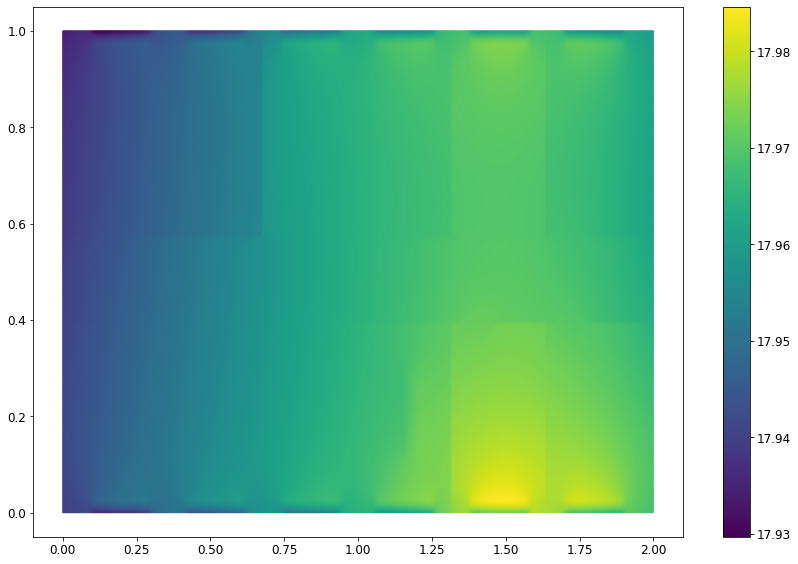

In [22]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

In [23]:
u = opt_fom.solve(mu_opt)
from pymor.discretizers.builtin.cg import (L2ProductP1, L2ProductQ1, InterpolationOperator)
from pymor.discretizers.builtin.grids.referenceelements import square
from pymor.discretizers.builtin.grids.boundaryinfos import EmptyBoundaryInfo
if data['grid'].reference_element is square:
    L2_OP = L2ProductQ1
else:
    L2_OP = L2ProductP1
if mu_d is None:
    empty_bi = EmptyBoundaryInfo(data['grid'])
    u_d = InterpolationOperator(data['grid'], ConstantFunction(u_d,2)).as_vector()
    diff= u.to_numpy()-u_d.to_numpy()
    diff_= opt_fom.solution_space.from_numpy(diff)
    Restricted_L2_OP = L2_OP(data['grid'], empty_bi, dirichlet_clear_rows=False, coefficient_function=domain_of_interest)
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]))
    print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]/Restricted_L2_OP.apply2(u_d,u_d)))

6.477934887508911e-05
[[1.71324989e-06]]


## Plot results

### J error

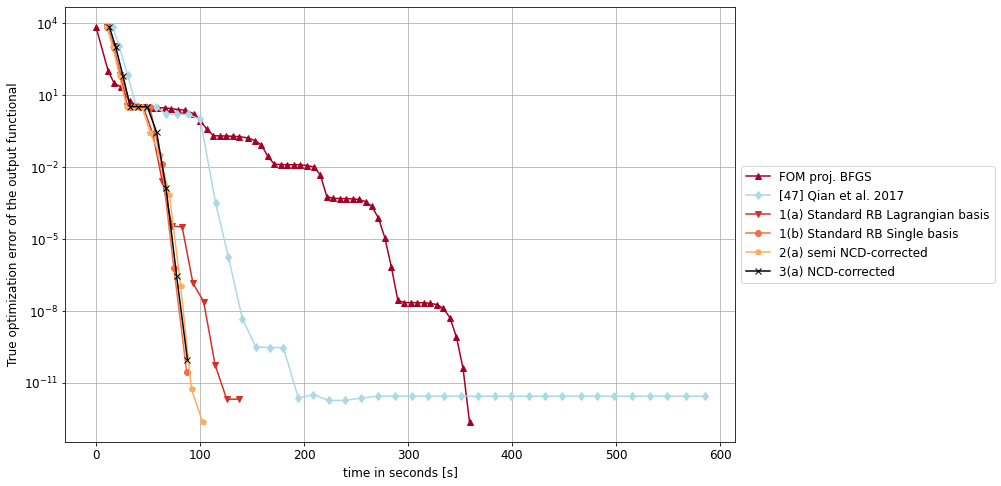

In [24]:
timings_figure = plt.figure()

color0 = (0.65,0,0.15)
color1 = (0.84,0.19,0.15)
color2 = (0.96,0.43,0.26)
color3 = (0.99,0.68,0.38)
color5 = (0.67,0.85,0.91)

#FOM
plt.semilogy(times_full_2,J_error_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,J_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,J_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,J_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,J_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,J_error_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot FOC

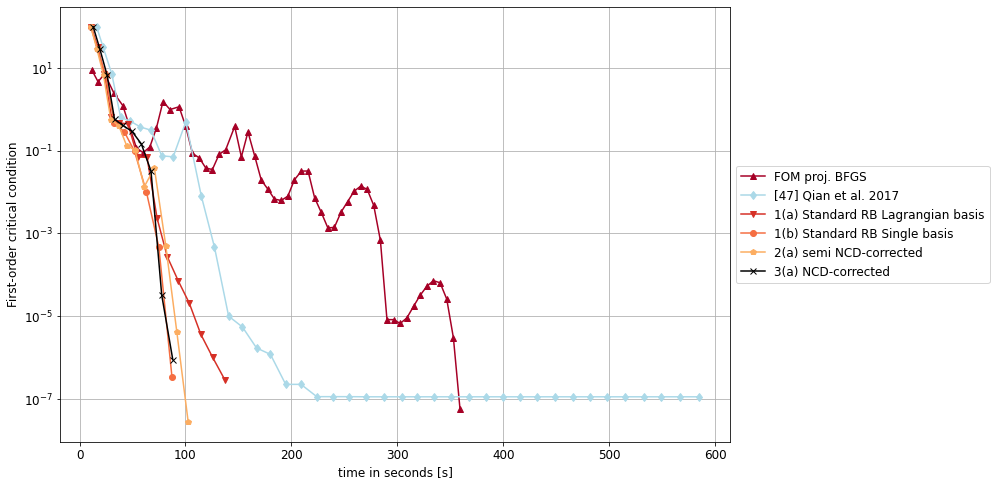

In [25]:
timings_figure = plt.figure()

#FOM
plt.semilogy(times_full_2[1:],FOC_2,'^-', color=color0, label='FOM proj. BFGS')

# Qian et al. 2017
plt.semilogy(times_full_26_actual,FOC_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

# Lagrange Basis
plt.semilogy(times_full_25_actual,FOC_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

# Unique Basis
plt.semilogy(times_full_54_actual,FOC_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

# Lagrange Basis
plt.semilogy(times_full_39_actual,FOC_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
plt.semilogy(times_full_23_actual,FOC_23_actual,'x-k', label='3(a) NCD-corrected')


plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Plot Mu error

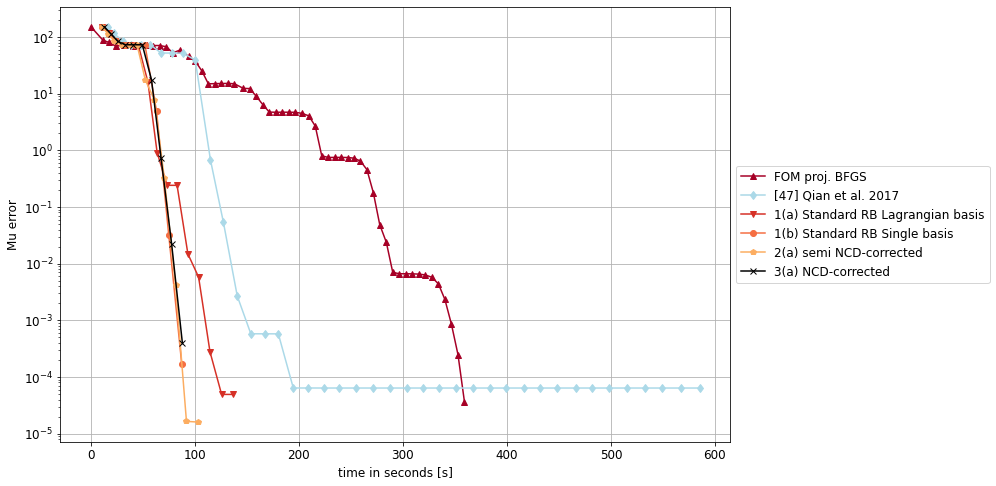

In [26]:
if mu_opt is not None:
    timings_figure = plt.figure()
    
    #FOM
    plt.semilogy(times_full_2,mu_error_2,'^-', color=color0, label='FOM proj. BFGS')

    # Qian et al. 2017
    plt.semilogy(times_full_26_actual,mu_error_26_actual,'d-', color=color5, label='[47] Qian et al. 2017')

    # Lagrange Basis
    plt.semilogy(times_full_25_actual,mu_error_25_actual,'v-', color=color1, label='1(a) Standard RB Lagrangian basis')

    # Unique Basis
    plt.semilogy(times_full_54_actual,mu_error_54_actual,'o-', color=color2, label='1(b) Standard RB Single basis')    

    # Lagrange Basis
    plt.semilogy(times_full_39_actual,mu_error_39_actual,'p-', color=color3, label='2(a) semi NCD-corrected')
    plt.semilogy(times_full_23_actual,mu_error_23_actual,'x-k', label='3(a) NCD-corrected')

    plt.xlabel('time in seconds [s]')
    plt.ylabel('Mu error')
    plt.grid()
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the data

In [27]:
#save data
from pdeopt.tools import save_data
directory = './results/Starter13'
save_data(directory, times_full_2, J_error_2, 2, mu_error=mu_error_2, FOC=FOC_2)
save_data(directory, times_full_23_actual, J_error_23_actual, 23, mu_error=mu_error_23_actual, FOC=FOC_23_actual)
save_data(directory, times_full_25_actual, J_error_25_actual, 25, mu_error=mu_error_25_actual, FOC=FOC_25_actual)
save_data(directory, times_full_26_actual, J_error_26_actual, 26, mu_error=mu_error_26_actual, FOC=FOC_26_actual)
save_data(directory, times_full_39_actual, J_error_39_actual, 39, mu_error=mu_error_39_actual, FOC=FOC_39_actual)
save_data(directory, times_full_54_actual, J_error_54_actual, 54, mu_error=mu_error_54_actual, FOC=FOC_54_actual)